In [3]:
import sys
import os

sys.path.append('/home/profes/miriamgf/tesis/Autoencoders/code/egm_reconstruction/Code/')


from config import TrainConfig_1
from config import TrainConfig_2
from config import DataConfig
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tools_ import freq_phase_analysis as freq_pha
from tools_ import plots
from tools_.preprocessing_network import *
from tools_.tools import *
from tools_.df_mapping import *
import tensorflow as tf
import os
import scipy
import datetime
import time
from evaluate_function import *
from numpy import *
import pickle
import sys
import mlflow
import itertools

sys.path.append('/code')
tf.random.set_seed(42)

root_logdir = '../output/logs/'
log_dir = root_logdir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
data_dir = '/home/profes/miriamgf/tesis/Autoencoders/Data/'
torsos_dir = '/home/profes/miriamgf/tesis/Autoencoders/Labeled_torsos/'
figs_dir = '../output/'
models_dir = '../output/model/'
dict_var_dir = '../output/variables/'
dict_results_dir = '../output/results/'


dic_vars = {}
dict_results = {}

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

start = time.time()

all_torsos_names = []
for subdir, dirs, files in os.walk(torsos_dir):
    for file in files:
        if file.endswith('.mat'):
            all_torsos_names.append(file)


all_model_names = []
directory = data_dir
for subdir, dirs, files in os.walk(directory):
    #print(subdir, directory, files)

    if (subdir != directory):
        model_name = subdir.split("/")[-1]
        all_model_names.append(model_name)


#Load data
df = load_egms_df(data_dir)

df.head(10)



Num GPUs: 2
data ['Simulation_01_200316_001_  7', 'Simulation_01_200212_001_  2', 'Simulation_01_210209_001_002', 'Simulation_01_210205_001_002', 'LA_RSPV_CAF_150115', 'Simulation_01_200428_001_001', 'Simulation_01_200316_001_  5', 'Simulation_01_191001_001_002', 'Simulation_01_200428_001_005', 'Simulation_01_190717_001_001', 'Simulation_01_200212_001_  7', 'Simulation_01_191001_001_007', 'Simulation_01_210205_001_001', 'LA_RSPV_150113', 'Simulation_01_210119_001_001', 'Simulation_01_210105_001_001', 'Simulation_01_210205_001_003', 'LA_PLAW_140612', 'Simulation_01_190717_001_004', 'Simulation_01_201223_001_002', 'Simulation_01_200212_001_  1', 'Simulation_01_210113_001_001', 'LA_LSPV_150203', 'Simulation_01_190619_001_003', 'Simulation_01_200428_001_003', 'Simulation_01_190619_001_004', 'Simulation_01_190717_001_003', 'Simulation_01_210108_001_001', 'Simulation_01_190502_001_006', 'LA_LSPV_150113', 'Simulation_01_190502_001_004', 'RA_RAFW_140807', 'Simulation_01_190717_001_002', 'Simul

,id,AF_signal
0,Simulation_01_200316_001_ 7,"[[2.9269744494331995, 2.9207875272468105, 2.88..."
1,Simulation_01_200212_001_ 2,"[[-22.921002513455925, -70.06590646544082, -13..."
2,Simulation_01_210209_001_002,"[[9.479828179102282e-14, 0.04080228461795585, ..."
3,Simulation_01_210205_001_002,"[[9.479828179102282e-14, 0.010746186426614766,..."
4,LA_RSPV_CAF_150115,"[[7.387776530722087, 9.094867906767199, 10.800..."
5,Simulation_01_200428_001_001,"[[0.8807414426522221, 1.015404814148348, 0.963..."
6,Simulation_01_200316_001_ 5,"[[2.7608773617825775, 2.882108416530383, 2.860..."
7,Simulation_01_191001_001_002,"[[38.55652570669007, 24.1416811551966, -35.930..."
8,Simulation_01_200428_001_005,"[[2.4146099647831396, 2.3764766416403464, 2.03..."
9,Simulation_01_190717_001_001,"[[16.700133247996128, 38.392383448362466, 26.4..."


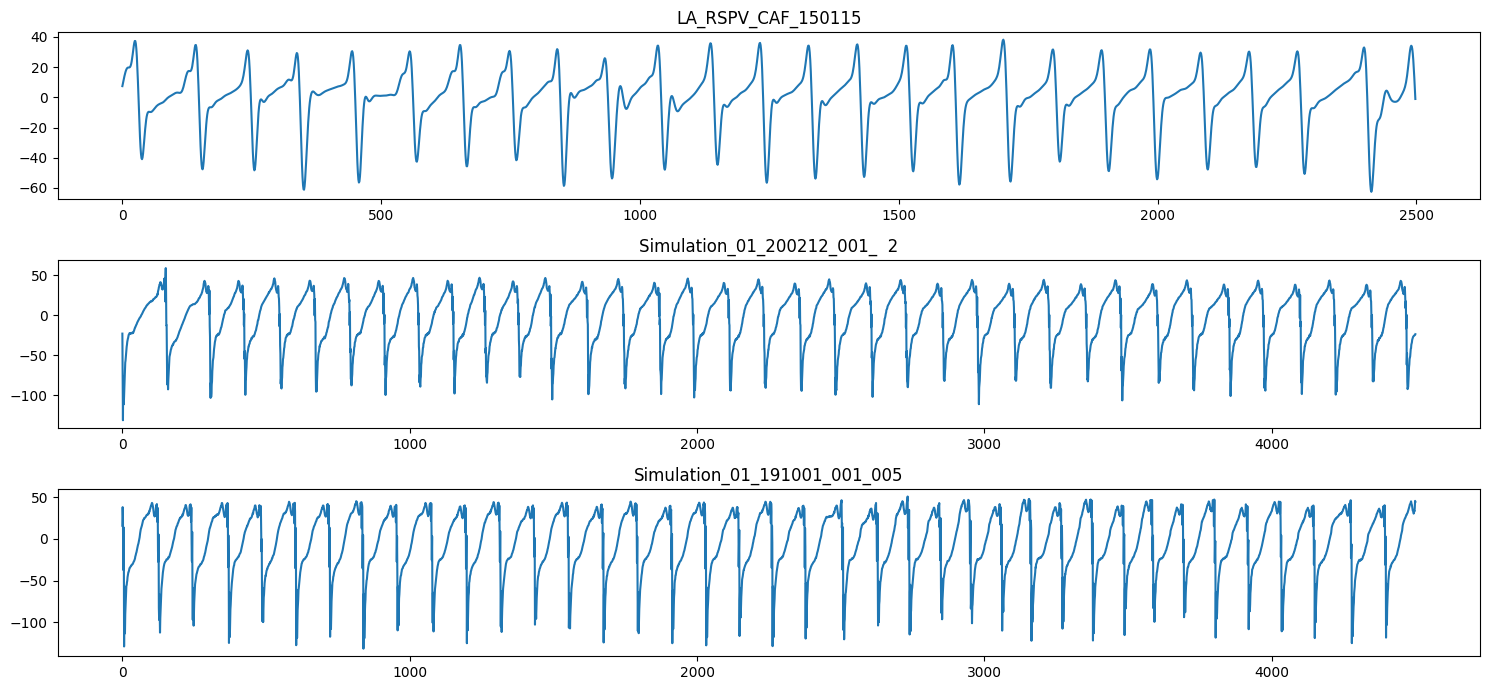

In [51]:
id_1 = 'LA_RSPV_CAF_150115'
id_2 = 'Simulation_01_200212_001_  2'
id_3 = 'Simulation_01_191001_001_005'
sig1 = np.array(df['AF_signal'][df['id'] == id_1])
sig2 = np.array(df['AF_signal'][df['id'] == id_2])
sig3 = np.array(df['AF_signal'][df['id'] == id_3])


plt.figure(figsize=(15,7),tight_layout=True)
plt.subplot(3, 1, 1)
plt.plot(sig1[0][0, :])
plt.title(id_1)
plt.subplot(3, 1, 2)
plt.plot(sig2[0][0, :])
plt.title(id_2)
plt.subplot(3, 1, 3)
plt.plot(sig3[0][0, :])
plt.title(id_3)
plt.show()